In [ ]:
!pip install -q transformers datasets evaluate scikit-learn

In [ ]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import evaluate
import numpy as np
import pandas as pd
import random


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if device == torch.device("cuda"):
        torch.cuda.manual_seed_all(seed)

set_seed(42)


Using device: cuda


In [ ]:
dataset = load_dataset("ag_news")
dataset


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")
def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True)
tokenized_datasets = dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [ ]:
model_checkpoint = "distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)



In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

encoded_dataset = dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=4).to(device)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
,You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')

    f1_macro = f1_score(labels, preds, average='macro')
    f1_micro = f1_score(labels, preds, average='micro')

    return {
        "accuracy": acc,
        "precision_weighted": precision,
        "recall_weighted": recall,
        "f1_weighted": f1,
        "f1_macro": f1_macro,
        "f1_micro": f1_micro,
    }


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,

    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    fp16=True,

    gradient_accumulation_steps=1,
    lr_scheduler_type="linear",

    logging_dir="./logs",
    logging_strategy="steps",
    logging_steps=50,
    report_to="none",
    run_name="agnews-text-classification",

    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True
)


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


/tmp/ipython-input-500228099.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
,  trainer = Trainer(


In [ ]:
trainer.train()
trainer.evaluate()



Epoch,Training Loss,Validation Loss,Accuracy,Precision Weighted,Recall Weighted,F1 Weighted,F1 Macro,F1 Micro
1,0.200500,0.184926,0.941842,0.941842,0.941842,0.941821,0.941821,0.941842
2,0.157800,0.189083,0.948289,0.948531,0.948289,0.948391,0.948391,0.948289
3,0.121700,0.205494,0.949342,0.949561,0.949342,0.949354,0.949354,0.949342


{'eval_loss': 0.20549380779266357,
 'eval_accuracy': 0.9493421052631579,
 'eval_precision_weighted': 0.9495608621288375,
 'eval_recall_weighted': 0.9493421052631579,
 'eval_f1_weighted': 0.9493540373268747,
 'eval_f1_macro': 0.9493540373268746,
 'eval_f1_micro': 0.9493421052631579,
 'eval_runtime': 25.6274,
 'eval_samples_per_second': 296.557,
 'eval_steps_per_second': 4.643,
 'epoch': 3.0}

In [ ]:

model.save_pretrained("classific")
tokenizer.save_pretrained("classific")


('classific/tokenizer_config.json',
 'classific/special_tokens_map.json',
 'classific/vocab.json',
 'classific/merges.txt',
 'classific/added_tokens.json',
 'classific/tokenizer.json')

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"


Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



,Classification Report:
,
,              precision    recall  f1-score   support
,
,       World       0.97      0.96      0.96      1900
,      Sports       0.99      0.99      0.99      1900
,    Business       0.93      0.91      0.92      1900
,    Sci/Tech       0.91      0.94      0.93      1900
,
,    accuracy                           0.95      7600
,   macro avg       0.95      0.95      0.95      7600
,weighted avg       0.95      0.95      0.95      7600
,


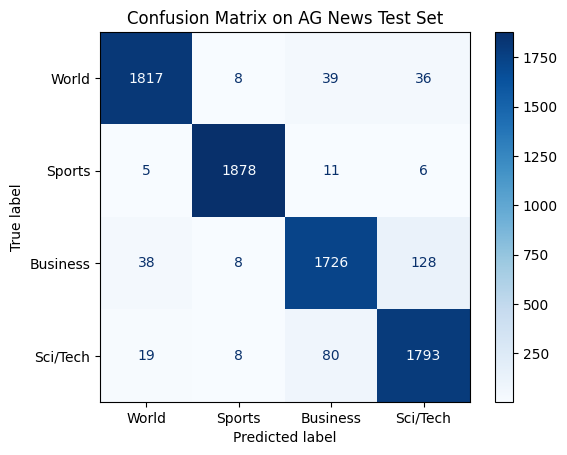


,Sample Predictions:
,
,Text: Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disap...
,True: Business | Predicted: Business | Confidence: 0.99
,--------------------------------------------------------------------------------
,Text: The Race is On: Second Private Team Sets Launch Date for Human Spaceflight (SPACE.com) SPACE.com - T...
,True: Sci/Tech | Predicted: Sci/Tech | Confidence: 1.00
,--------------------------------------------------------------------------------
,Text: Ky. Company Wins Grant to Study Peptides (AP) AP - A company founded by a chemistry researcher at th...
,True: Sci/Tech | Predicted: Sci/Tech | Confidence: 1.00
,--------------------------------------------------------------------------------
,Text: Prediction Unit Helps Forecast Wildfires (AP) AP - It's barely dawn when Mike Fitzpatrick starts his...
,True: Sci/Tech | Predicted: Sci/Tech | Confidence: 0.99
,---------------------------------------------------------

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import torch

model = AutoModelForSequenceClassification.from_pretrained("classific")
tokenizer = AutoTokenizer.from_pretrained("classific")

dataset = load_dataset("ag_news")
test_dataset = dataset["test"]

def tokenize(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

test_encoded = test_dataset.map(tokenize, batched=True)
test_encoded.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

trainer = Trainer(model=model)
predictions = trainer.predict(test_encoded)

preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

print("\nClassification Report:\n")
print(classification_report(labels, preds, target_names=dataset["train"].features["label"].names))

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset["train"].features["label"].names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix on AG News Test Set")
plt.show()

print("\nSample Predictions:\n")
softmax = torch.nn.Softmax(dim=1)
probs = softmax(torch.tensor(predictions.predictions))

for i in range(5):
    text = test_dataset[i]['text']
    true_label = dataset["train"].features["label"].names[labels[i]]
    pred_label = dataset["train"].features["label"].names[preds[i]]
    confidence = probs[i][preds[i]].item()
    print(f"Text: {text[:100]}...")
    print(f"True: {true_label} | Predicted: {pred_label} | Confidence: {confidence:.2f}")
    print("-" * 80)


In [ ]:
ls results/


checkpoint-15000/  checkpoint-22500/


In [ ]:
import torch
from transformers import AutoModelForSequenceClassification
from google.colab import files

checkpoint_path = "./results/checkpoint-22500"
save_path = "./model.pth"


model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint_path,
    local_files_only=True
)


torch.save(model.state_dict(), save_path)


files.download(save_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>